# Impact of factors on retention

### Import libraries

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


#from sklearn.preprocessing import MinMaxScaler
#import geopandas as gpd

### Read in and process dependent variable

Read turnover data from csv into a dataframe.

In [216]:
# annual and monthly data

annual_url = '../01_data/processed_annual_turnover.csv'
monthly_url = '../01_data/processed_monthly_turnover.csv'

annual_df = pd.read_csv(annual_url, parse_dates=['month_year'])
annual_df = annual_df.drop(['n'],axis=1)
#annual_df.info()

monthly_df = pd.read_csv(monthly_url, parse_dates=['month_year'])
monthly_df = monthly_df.drop(['n'],axis=1)
monthly_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147107 entries, 0 to 147106
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     147107 non-null  object        
 1   region_name  147107 non-null  object        
 2   org_type     147107 non-null  object        
 3   staff_group  147107 non-null  object        
 4   month_year   147107 non-null  datetime64[ns]
 5   join_HC      109986 non-null  float64       
 6   join_FTE     109986 non-null  float64       
 7   leave_HC     110122 non-null  float64       
 8   leave_FTE    110122 non-null  float64       
 9   denom_HC     146797 non-null  float64       
 10  denom_FTE    146797 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 12.3+ MB


Function to clean and process DV dataframes

In [219]:
def clean_dv(df):
    # add leaver and joiner rates column
    df['leaver_rate'] = df['leave_FTE']/df['denom_FTE']
    df['joiner_rate'] = df['join_FTE']/df['denom_FTE']

    # drop unneeded HC columns
    df = df.drop(['join_HC','leave_HC','denom_HC'],axis=1)
    # drop 'All staff groups' - use sum of all others instead when wanting all staff.
    df.drop(df[df['staff_group'] == 'All staff groups'].index, inplace = True)
    ## calculate a columns with % of staff groups by organisation and date
    # first, calculate a total staff in post (SIP; all staff) FTE column for each organisation by month.
    df_sip = df.groupby(['month_year', 'org_code', 'staff_group','region_name'])['denom_FTE'].sum().reset_index()

    # second, group by 'month_year' and 'org_code' and sum the 'FTE' values for each group
    df_total_sip_FTE = df_sip.groupby(['month_year', 'org_code','region_name'])['denom_FTE'].sum().reset_index()
    
    # third, merge the total_sip_FTE DataFrame back into the original DataFrame 
    df2 = pd.merge(df, df_total_sip_FTE, on=['month_year', 'org_code','region_name'], suffixes=('', '_total'))
    
    df2.rename(columns={'denom_FTE_total': 'total_sip_FTE'}, inplace=True)

    # fourth, calculate the percentage of staff group FTE by organization and date
    df2['%_FTE'] = df2['denom_FTE'] / df2['total_sip_FTE']

    # fifth, pivot the DataFrame to get staff groups as new columns with % values
    df3 = df2.pivot(index=['month_year', 'org_code','region_name'], columns='staff_group', values='%_FTE').reset_index()

    # finally, merge the pivot DataFrame with the original DataFrame
    df4 = pd.merge(df2, df3, on=['month_year', 'org_code','region_name'])

    # make the new staff group name columns friendlier
    df4.rename(columns={'Ambulance staff': '%_amb_staff','Central functions':'%_cent_funct','HCHS doctors (exc. junior Drs)': '%_senior_docs',
    'Hotel, property & estates': '%_estates', 'Managers':'%_managers','Nurses & health visitors': '%_nurses_hv',
    'Other staff or those with unknown classification':'%_unknown','Scientific, therapeutic & technical staff':'%_sci_tech_staff',
    'Senior managers':'%senior_managers','Support to ST&T staff': '%_supp_sci_tech','Support to doctors, nurses & midwives': '%_supp_doc_nur_mid',
    'Midwives':'%_midwives','Support to ambulance staff': '%_supp_amb_staff'}, inplace=True)

    # replace inf values with nan (can happen with rate calcs)
    df4.replace([np.inf, -np.inf], np.nan, inplace=True)
    # transform nans to zeros
    df4.fillna(0, inplace=True)

    # Add a small constant to avoid taking the log of zero
    small_constant = 1e-5
    
    # log scale the total_SIP_FTE column to be in line with other variables. proxy for size of organisation
    df4['log_total_sip_FTE'] = np.log(df4['total_sip_FTE'] + small_constant)

    # drop %_FTE column
    df4.drop(['join_FTE','leave_FTE','%_FTE','total_sip_FTE','denom_FTE'], axis=1, inplace=True)

    return df4

In [217]:
annual_df = clean_dv(annual_df)
monthly_df = clean_dv(monthly_df)

  org_code region_name          org_type                     staff_group  \
0      R0A  North West  Acute - Teaching                 Ambulance staff   
1      R0A  North West  Acute - Teaching               Central functions   
2      R0A  North West  Acute - Teaching  HCHS doctors (exc. junior Drs)   
3      R0A  North West  Acute - Teaching       Hotel, property & estates   
4      R0A  North West  Acute - Teaching                        Managers   

  month_year   join_FTE  leave_FTE   denom_FTE  leaver_rate  joiner_rate  \
0 2020-02-01        NaN        NaN     1.00000          NaN          NaN   
1 2020-02-01  344.46002  188.60666  1659.63378     0.113644     0.207552   
2 2020-02-01  102.74834   68.70484  1253.83751     0.054796     0.081947   
3 2020-02-01   58.41334   22.42668   386.47879     0.058028     0.151142   
4 2020-02-01   38.61351   15.48000   189.07166     0.081874     0.204227   

   denom_FTE_total  
0      19970.15747  
1      19970.15747  
2      19970.15747  
3 

In [218]:
annual_df.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,leaver_rate,joiner_rate,%_amb_staff,...,%_managers,%_midwives,%_nurses_hv,%_unknown,%_sci_tech_staff,%senior_managers,%_supp_sci_tech,%_supp_amb_staff,%_supp_doc_nur_mid,log_total_sip_FTE
0,R0A,North West,Acute - Teaching,Ambulance staff,2020-02-01,0.00000,0.00000,0.000000,0.000000,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
1,R0A,North West,Acute - Teaching,Central functions,2020-02-01,344.46002,188.60666,0.113644,0.207552,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
2,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2020-02-01,102.74834,68.70484,0.054796,0.081947,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
3,R0A,North West,Acute - Teaching,"Hotel, property & estates",2020-02-01,58.41334,22.42668,0.058028,0.151142,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
4,R0A,North West,Acute - Teaching,Managers,2020-02-01,38.61351,15.48000,0.081874,0.204227,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994


The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

In [160]:
annual_df['staff_group'].unique()

array(['Ambulance staff', 'Central functions',
       'HCHS doctors (exc. junior Drs)', 'Hotel, property & estates',
       'Managers', 'Nurses & health visitors',
       'Other staff or those with unknown classification',
       'Scientific, therapeutic & technical staff', 'Senior managers',
       'Support to ST&T staff', 'Support to doctors, nurses & midwives',
       'Midwives', 'Support to ambulance staff'], dtype=object)

## Load independent variable 1 - local unemployment

Load data about local unemployment so we can use it as a regressor

In [161]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.tail()

,Date,Region,NHSE region name,%,thousands
3343,2023-03-01,North West,North West,0.030,107
3344,2023-03-01,South East,South East,0.037,177
3345,2023-03-01,South West,South West,0.031,89
3346,2023-03-01,West Midlands,Midlands,0.048,147
3347,2023-03-01,York & the Humber,North East and Yorkshire,0.038,104


In [162]:
df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.head()

,month_year,region_name,local_unemployment
0,1992-04-01,Midlands,0.087
1,1992-04-01,East of England,0.079
2,1992-04-01,London,0.123
3,1992-04-01,North East,0.122
4,1992-04-01,North West,0.101


## Load IV 2 - sickness absence

Load data about sickness absence to use as second regressor

In [163]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['Benchmark group','Org name',
                    'NHSE region code','Cluster group'],axis=1)
df_r2.rename(columns={'Org code':'org_code','Date':'month_year',
                      'NHSE region name':'region_name','Staff group':'staff_group',
                      'FTE days lost':'fte_days_lost','FTE days available':'fte_days_available'},inplace=True)
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_r2['sickness_absence'] = df_r2['fte_days_lost']/df_r2['fte_days_available']
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241185 entries, 0 to 241184
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          241185 non-null  datetime64[ns]
 1   org_code            241185 non-null  object        
 2   region_name         241185 non-null  object        
 3   staff_group         241185 non-null  object        
 4   fte_days_lost       241185 non-null  float64       
 5   fte_days_available  241185 non-null  float64       
 6   sickness_absence    240931 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 12.9+ MB


Create 12-month rolling sickness absence column for use with annual turnover data

In [182]:
df_r2['month_year'] = pd.to_datetime(df_r2['month_year'])

# Sort the DataFrame by 'organisation', 'staff_group', and 'month'
df_r2.sort_values(by=['org_code', 'staff_group', 'month_year'], inplace=True)

# Calculate the rolling sums for days lost and days available
df_r2['rolling_days_lost'] = df_r2.groupby(['org_code', 
                        'staff_group'])['fte_days_lost'].rolling(window=12, min_periods=1).sum().reset_index(level=[0, 1], drop=True)

df_r2['rolling_days_available'] = df_r2.groupby(['org_code', 
                        'staff_group'])['fte_days_available'].rolling(window=12, min_periods=1).sum().reset_index(level=[0, 1], drop=True)

# Calculate the rolling sickness absence rate
df_r2['annual_sickness_absence'] = df_r2['rolling_days_lost'] / df_r2['rolling_days_available']

# drop fte_days_lost fte_days_available, rolling_days_available and rolling_days_lost columns
df_r2.drop(columns=['fte_days_lost', 'fte_days_available', 'rolling_days_available', 'rolling_days_lost'], inplace=True)

df_r2.head()

,month_year,org_code,region_name,staff_group,sickness_absence,annual_sickness_absence
523,2018-03-01,0AR,Special Health Authorities and other statutory...,All staff groups,0.030707,0.030707
7395,2018-04-01,0AR,Special Health Authorities and other statutory...,All staff groups,0.038024,0.034318
12211,2018-05-01,0AR,Special Health Authorities and other statutory...,All staff groups,0.039730,0.036162
18374,2018-06-01,0AR,Special Health Authorities and other statutory...,All staff groups,0.033094,0.035407
22005,2018-07-01,0AR,Special Health Authorities and other statutory...,All staff groups,0.031692,0.034648


## Load IV 3 - reasons for sickness absence

Add data about reasons for sickness absence

In [195]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# drop least frequent reasons for absence
df_r3 = df_r3.drop(['substance_abus','asthma',
                    'dental','blood_disorder','endocrine',
                    'eye','skin_disorders','nervous_system'],axis=1)

# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()
# Note not broken down by organisation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1374 non-null   datetime64[ns]
 1   staff_group        1374 non-null   object        
 2   anxiety_stress     1374 non-null   float64       
 3   back_problems      1374 non-null   float64       
 4   gastro             1374 non-null   float64       
 5   gynaecological     1374 non-null   float64       
 6   headache_mig       1374 non-null   float64       
 7   infectious_dis     1374 non-null   float64       
 8   other              1374 non-null   float64       
 9   other_msk          1374 non-null   float64       
 10  pregnancy_related  1374 non-null   float64       
 11  respiratory        1374 non-null   float64       
 12  unknown            1374 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 139.

## Load IV 4 - staff vacancies

## Merge IV dfs to main df

In [220]:
annual_df.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,leaver_rate,joiner_rate,%_amb_staff,...,%_managers,%_midwives,%_nurses_hv,%_unknown,%_sci_tech_staff,%senior_managers,%_supp_sci_tech,%_supp_amb_staff,%_supp_doc_nur_mid,log_total_sip_FTE
0,R0A,North West,Acute - Teaching,Ambulance staff,2020-02-01,0.00000,0.00000,0.000000,0.000000,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
1,R0A,North West,Acute - Teaching,Central functions,2020-02-01,344.46002,188.60666,0.113644,0.207552,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
2,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2020-02-01,102.74834,68.70484,0.054796,0.081947,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
3,R0A,North West,Acute - Teaching,"Hotel, property & estates",2020-02-01,58.41334,22.42668,0.058028,0.151142,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994
4,R0A,North West,Acute - Teaching,Managers,2020-02-01,38.61351,15.48000,0.081874,0.204227,0.00005,...,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,0.0,0.244138,9.901994


In [251]:
def merge_ivs(df, df_r1, df_r2, df_r3):
    df1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
    df1 = df1.sort_values('month_year')

    r2_merge_cols = ['month_year', 'org_code','region_name','staff_group']
    df2 = pd.merge(df1, df_r2, on=r2_merge_cols,how='left')
    df2.drop_duplicates(subset=r2_merge_cols)

    r3_merge_cols = ['month_year','staff_group']
    df3 = pd.merge(df2, df_r3, on=r3_merge_cols,how='left')

    # Need to cut dataframe to earliest and latest data available for all fields. Do this by cutting rows where all values for key variables are zero
    df3 = df3[~((df3['leaver_rate'] == 0) | (df3['joiner_rate'] == 0) | (df3['sickness_absence'] == 0))]

    # transform nans into 0s
    df3 = df3.fillna(0)
    
    return df3

In [252]:
annual_df_ivs = merge_ivs(annual_df,df_r1, df_r2, df_r3)
monthly_df_ivs = merge_ivs(monthly_df,df_r1, df_r2, df_r3)


In [253]:
annual_df_ivs.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,leaver_rate,joiner_rate,%_amb_staff,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
48754,RNQ,Midlands,Acute - Small,Support to ST&T staff,2018-08-01,33.55999,23.78000,0.107967,0.152370,0.002214,...,0.066669,0.118258,0.055797,0.026947,0.007138,0.105720,0.148568,0.024099,0.029760,0.050024
48755,RNQ,Midlands,Acute - Small,Support to ST&T staff,2018-08-01,33.55999,23.78000,0.107967,0.152370,0.002214,...,0.066669,0.118258,0.055797,0.026947,0.007138,0.105720,0.148568,0.024099,0.029760,0.050024
48757,RNQ,Midlands,Acute - Small,Support to ST&T staff,2018-08-01,33.55999,23.78000,0.107967,0.152370,0.002214,...,0.066669,0.118258,0.055797,0.026947,0.007138,0.105720,0.148568,0.024099,0.029760,0.050024
48758,RNQ,Midlands,Acute - Small,Support to ST&T staff,2018-08-01,33.55999,23.78000,0.107967,0.152370,0.002214,...,0.066669,0.118258,0.055797,0.026947,0.007138,0.105720,0.148568,0.024099,0.029760,0.050024
48759,RWF,South East,Acute - Large,Central functions,2018-08-01,68.21333,56.86933,0.129749,0.155631,0.000444,...,0.058472,0.118626,0.044647,0.032455,0.007409,0.104473,0.093763,0.020213,0.024584,0.053016


Add month of year as a variable

In [61]:
# Extract the month from the 'Date' column and create a new column
# df_leaver_r3['month'] = df_leaver_r3['month_year'].dt.month

In [62]:
# Extract the month from the 'Date' column and create a new column
# df_leaver_r3['year'] = df_leaver_r3['month_year'].dt.year

drop duplicate rows

In [63]:
 #de-duplicate
# df_leaver_r3 = df_leaver_r3.drop_duplicates().reset_index()

Explore independent and dependent variables

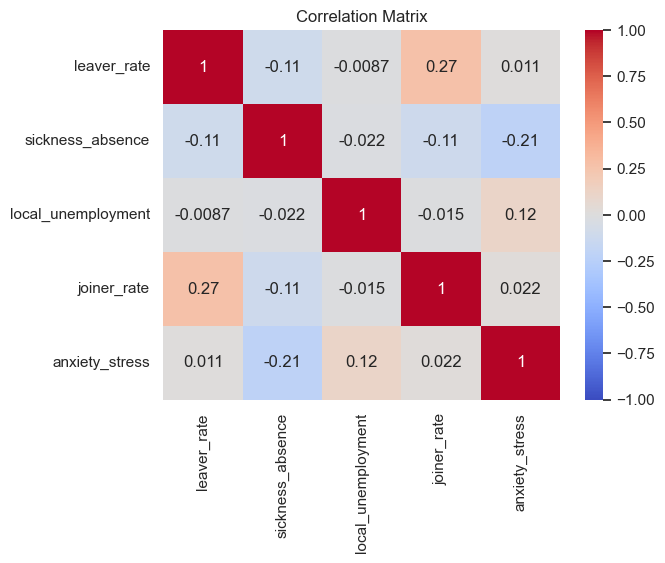

In [254]:
corr_cols = ['leaver_rate', 'sickness_absence',
                                   'local_unemployment','joiner_rate','anxiety_stress']
correlation_matrix = annual_df_ivs[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [255]:
sorted(annual_df_ivs['staff_group'].unique())

['Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [256]:
staff_group = 'Nurses & health visitors'
df_sg = annual_df_ivs[annual_df_ivs['staff_group'] == staff_group].copy()

#df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
#df_sg['leaver_rate'] = df_sg['leave_FTE']/df_sg['denom_FTE']

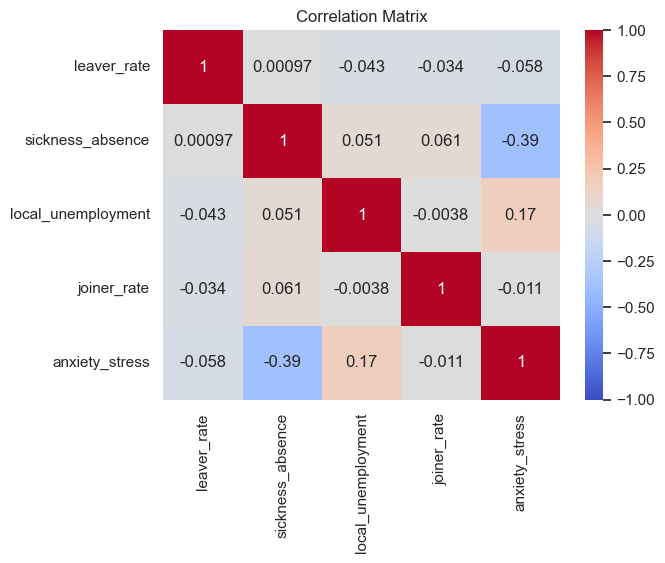

In [257]:
correlation_matrix = df_sg[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

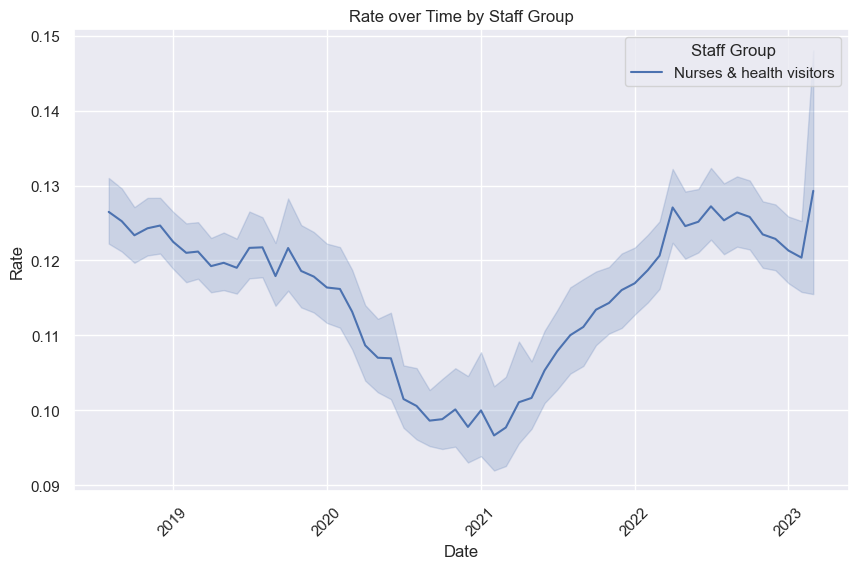

In [258]:
df_sg
sns.set()

plt.figure(figsize=(10, 6))  
sns.lineplot(data=df_sg, x='month_year', y='leaver_rate', hue='staff_group')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate over Time by Staff Group')
plt.legend(title='Staff Group', loc='best')  
plt.xticks(rotation=45)  
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [69]:
#ivs_cat = ['region_name','staff_group']
#df_with_dummies = pd.get_dummies(df_m, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

In [70]:
annual_df_ivs.to_csv(f'annual_modelling_data.csv', index=False)

In [71]:
#df_sg.to_csv(f'sg_modelling_data_to_check.csv', index=False)


Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [263]:
dv = 'leaver_rate'
#ivs = ['local_unemployment','sickness_absence_rate','joiner_rate','sip_FTE']
to_drop = ['month_year','org_code','region_name','org_type','staff_group',
           'join_FTE','leave_FTE','gastro','other','pregnancy_related', dv]

Define the design matrix (X) and the dependent variable (y)


In [264]:
annual_df_ivs.reset_index(drop = True)
X = annual_df_ivs.drop(to_drop, axis=1)
y = annual_df_ivs[dv]

#y = y.dropna()

y.head()


48754    0.107967
48755    0.107967
48757    0.107967
48758    0.107967
48759    0.129749
Name: leaver_rate, dtype: float64

In [265]:

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,joiner_rate,%_amb_staff,%_cent_funct,%_senior_docs,%_estates,%_managers,%_midwives,%_nurses_hv,%_unknown,...,sickness_absence,annual_sickness_absence,anxiety_stress,back_problems,gynaecological,headache_mig,infectious_dis,other_msk,respiratory,unknown
285177,1.0,0.048015,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,0.276413,0.0,...,0.009252,0.009502,0.430227,0.022413,0.030542,0.028041,0.049080,0.057015,0.074477,0.064931
285178,1.0,0.048015,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,0.276413,0.0,...,0.009252,0.009502,0.430227,0.022413,0.030542,0.028041,0.049080,0.057015,0.074477,0.064931
285179,1.0,0.150719,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,0.276413,0.0,...,0.050532,0.057499,0.347314,0.033409,0.051420,0.022050,0.076531,0.099049,0.066442,0.031839
285180,1.0,0.143157,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,0.276413,0.0,...,0.064122,0.070576,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185
285181,1.0,0.192754,0.00000,0.080482,0.035639,0.052838,0.025495,0.000000,0.293805,0.0,...,0.071158,0.080616,0.310589,0.054337,0.038150,0.029438,0.070536,0.120188,0.079074,0.029342


In [266]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     815.4
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:41:17   Log-Likelihood:                -14846.
No. Observations:              209344   AIC:                         2.974e+04
Df Residuals:                  209318   BIC:                         3.001e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [76]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              -89.7939      2.370    -37.894      0.000     -94.438     -85.149
index                                            -9.136e-07   2.61e-08    -35.004      0.000   -9.65e-07   -8.62e-07
joiner_rate                                          0.1000      0.002     40.725      0.000       0.095       0.105
total_sip_FTE                                    -2.209e-06   6.97e-08    -31.670      0.000   -2.35e-06   -2.07e-06
Ambulance staff                                     -7.0254      0.182    -38.558      0.000      -7.383      -6.668
Central functions                                   -7.0075      0.182    -38.582      0.000      -7.363      -6.652
HCHS doctors (exc. junior Drs)                      -6.9699     